<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Effective computation in Biomechanics
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))

<!--NAVIGATION-->
< [Advanced statistical analysis of biomechanical time series](04.00-Time-series-statistics.ipynb) | [Contents](Index.ipynb) | [Useful programming stuff](05.00-Useful-programming-stuff.ipynb) >

# Statistical Parametric Mapping (SPM)

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

## Get the data

Our data sample does not contain enough observations to perform statistical analysis. We will therefore use a data set from the following article:

> [How gender and boat-side affect shape characteristics of force-angle profiles in single sculling: Insights from functional data analysis](https://www.ncbi.nlm.nih.gov/pubmed/28958487)

Our goal is to examine whether gender influenced the force in on-water single sculling.

In [43]:
DATA_FILE = Path("../data/") / "warmenhoven_2018.csv"

forces = pd.read_csv(DATA_FILE)
forces.head()

,participant,frame,force,sex
0,0,0,54.781383,male
1,0,1,64.882417,male
2,0,2,76.281664,male
3,0,3,98.179651,male
4,0,4,121.595107,male


## Visualize the data

Before performing any statistical analysis or calculation, a mandatory step is to visualize the raw and averaged data.

In [44]:
def plot_data(data, raw=False):
    plt.figure(figsize=(12, 6))

    if raw:
        sns.lineplot(
            x="frame",
            y="force",
            hue="sex",
            units="participant",
            estimator=None,
            data=data,
        )
    else:
        sns.lineplot(x="frame", y="force", hue="sex", data=data)

    plt.xlabel("Frame")
    plt.ylabel("Force (N)")

    plt.legend(frameon=False)

    sns.despine()

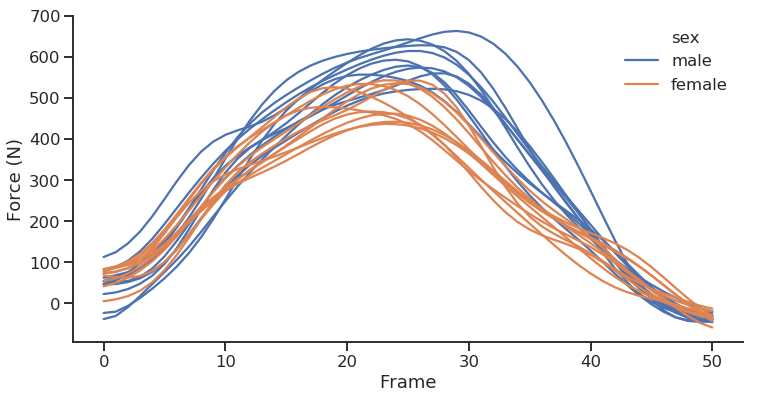

In [45]:
plot_data(forces, raw=True)

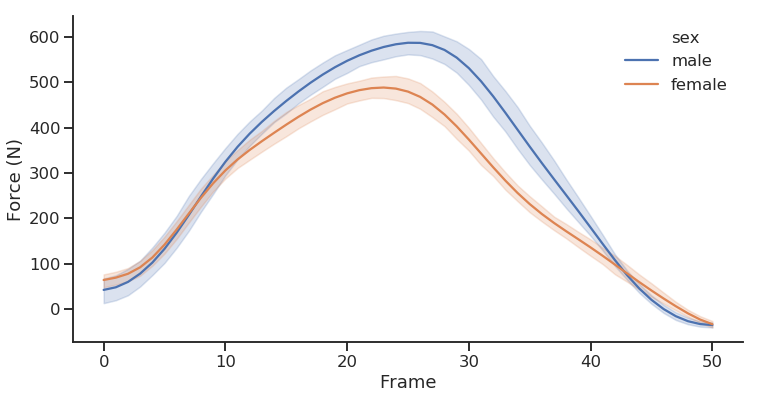

In [46]:
plot_data(forces)

## Choosing a statistical method

Statistical Parametric Mapping (SPM) is the state of the art technique for examining brain activity recorded during functional neuroimaging (almost 10,000 citations on the paper [Statistical parametric maps in functional imaging: a general linear approach](https://onlinelibrary.wiley.com/doi/abs/10.1002/hbm.460020402) by Friston et al., 1994).
This technique in biomechanics was introduced by Todd Pataky and his team about ten years ago ([some articles](https://scholar.google.fr/scholar?hl=en&as_sdt=0%2C5&q=%22todd+pataky%22+AND+%22statistical+parametric+mapping%22&btnG=)).

Because most of the experimental data in biomechanics can be described as "1D continua" (e.g., time-dependent), then SPM is an appropriate statistical methodology to consider.

SPM conducts statistical testing at the continuum level, in a conceptually simple manner:

- For 0D (univariate) datasets, which are the focus of most basic statistics textbooks, statistical inference stems from a model of randomness, usually the Gaussian distribution. The goal is to quantify the probability that random data would exceed a particular test statistic value (like t = 2.5 or F = 10.1).
- For 1D datasets, SPM-based statistical testing is conceptually identical: the goal is to quantify the probability that smooth, random 1D continua would produce a test statistic continuum whose maximum exceeds a particular test statistic value.

In our example, women's and men's forces will be compared using the [spm1d](http://www.spm1d.org/) package.

This method avoids information loss associated with standard methods which reduce time series into a single, arbitrary, data point (such as mean, median or maximum), while controlling for type a-error due to multiple comparisons.

## Choosing a test

- How many variables?: 1 (force)
- How many factors?: 1 (gender)
- Same sample?: no
 
We will therefore use a _two-sample t-test_

## Data organization in spm1d

### T-test

![t-test_org](https://raw.githubusercontent.com/pyomeca/tutorials/master/notebooks/images/t-test_org.svg?sanitize=true)

### ANOVA
![anova_org](https://raw.githubusercontent.com/pyomeca/tutorials/master/notebooks/images/anova_org.svg?sanitize=true)

### Hotelling's T2
![hotelling_org](https://raw.githubusercontent.com/pyomeca/tutorials/master/notebooks/images/hotelling_org.svg?sanitize=true)

### MANOVA
![manova_org](https://raw.githubusercontent.com/pyomeca/tutorials/master/notebooks/images/manova_org.svg?sanitize=true)

In [47]:
forces.head()

,participant,frame,force,sex
0,0,0,54.781383,male
1,0,1,64.882417,male
2,0,2,76.281664,male
3,0,3,98.179651,male
4,0,4,121.595107,male


In [48]:
male = (
    forces.query('sex == "male"')
    .set_index(["participant", "frame"])["force"]
    .unstack()
)

female = (
    forces.query('sex == "female"')
    .set_index(["participant", "frame"])["force"]
    .unstack()
)

female

frame,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
participant,,,,,,,,,,,,,,,,,,,,,
10,67.826838,64.649818,63.338198,67.004395,79.125776,101.035895,131.625319,167.635489,205.235303,241.360352,...,100.632738,80.328530,59.284494,39.196998,21.207635,5.500164,-8.369344,-20.530561,-30.369392,-37.256374
11,41.879450,50.128846,63.031127,80.541087,102.981567,130.839598,163.578577,199.521878,236.426842,272.165713,...,125.632237,103.405626,80.494023,57.435244,34.570223,11.990879,-10.098596,-30.704739,-47.632484,-58.586953
12,83.778417,90.446288,102.592601,121.318718,147.405271,179.978725,217.087880,256.080310,294.046161,328.569156,...,146.377113,130.111835,111.602432,90.842920,68.383631,45.051837,21.797563,-0.069103,-18.743894,-32.357794
13,82.951749,89.031409,95.966274,106.382340,122.136570,144.012580,170.957850,200.368607,229.038917,254.396500,...,159.873578,146.654750,130.777914,111.427182,88.708130,63.583431,37.515115,12.101591,-11.219421,-30.972891
14,5.396880,10.051680,17.884610,31.116350,51.868691,81.248151,117.948136,160.157188,205.360767,249.161495,...,103.517437,84.054914,65.419989,49.063001,35.510485,24.202292,13.967722,3.897797,-5.579145,-12.722531
15,73.373480,78.154850,85.646189,98.420669,117.652593,143.287231,173.159129,204.021840,233.004155,258.826189,...,135.422944,108.100345,80.626025,54.660570,31.192401,10.480395,-7.313419,-21.404095,-30.836045,-35.838726
16,82.433038,86.782997,93.954325,107.482353,128.798075,157.294135,190.759288,226.533014,262.648099,297.925876,...,119.369255,98.570209,76.213378,54.284575,34.837725,18.991530,6.521766,-3.544313,-11.925262,-18.629696
17,73.071385,76.724955,86.786181,105.629160,134.284214,170.805279,211.575803,252.807849,291.451385,325.783395,...,54.624528,39.399005,27.484025,18.523884,11.519815,4.882759,-2.850571,-12.084139,-21.924540,-30.769399
18,77.318172,86.993730,96.947265,114.680783,140.698096,173.699978,209.974223,244.906345,274.777074,297.948044,...,142.322459,126.750264,109.538024,89.936562,68.002185,44.450083,20.263035,-3.403164,-24.998344,-42.638013


## Conduct a t-test with spm1d

In [49]:
import spm1d

alpha = 0.05
two_tailed = True

In [50]:
# compute the test statistic value 
t_test = spm1d.stats.ttest2(male.values, female.values)

# conduct statistical inference
t_test_inf = t_test.inference(alpha, two_tailed=two_tailed)

t_test_inf

SPM{T} inference field
   SPM.z         :  (1x51) raw test stat field
   SPM.df        :  (1, 17.234)
   SPM.fwhm      :  9.34761
   SPM.resels    :  (1, 5.34896)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  3.36502
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (<0.001)



-`alpha`: type I error rate

-`zstar`: critical threshold zstar

-`h0reject`: null hyothesis rejection decision

-`p`: cluster-specific probability values

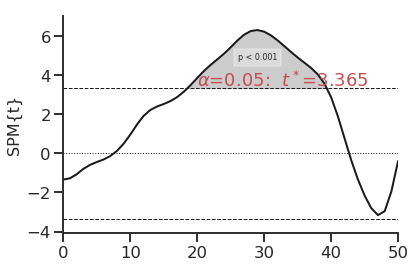

In [51]:
t_test_inf.plot()
t_test_inf.plot_p_values()
t_test_inf.plot_threshold_label()

sns.despine()

Results indicate a significant between-group difference (p < 0.001) between approximately Frame 18 and 40. 

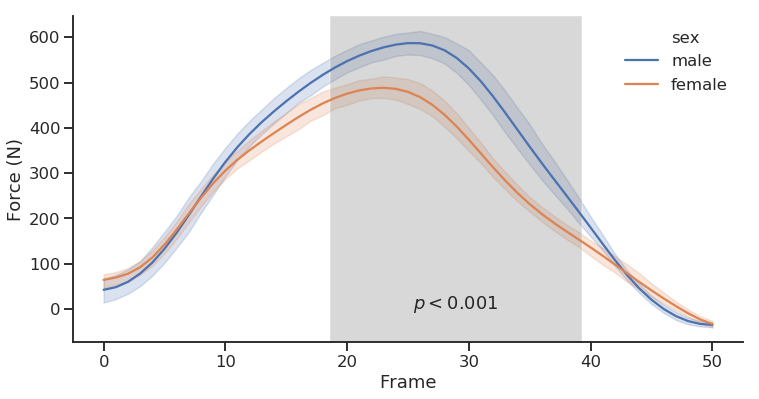

In [52]:
cluster = [t_test_inf.clusters[0].endpoints[0], t_test_inf.clusters[0].endpoints[1]]
p = u"$p<0.001$" if t_test_inf.p_set < 0.001 else t_test_inf.p_set

plot_data(forces)

plt.axvspan(cluster[0], cluster[1], facecolor="gray", alpha=0.3)

plt.text(x=np.mean(cluster), y=0, s=p, horizontalalignment="center")

sns.despine()

# Statistical non-Parametric Mapping (SnPM)

In [53]:
# compute the test statistic value 
nt_test = spm1d.stats.nonparam.ttest2(male.values, female.values)

# conduct statistical inference
nt_test_inf = nt_test.inference(alpha, two_tailed=two_tailed, iterations=10000)

nt_test_inf

SnPM{T} inference field
   SPM.z              :  (1x51) raw test stat field
   SnPM.nPermUnique   :  184756 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  3.18900
   SPM.h0reject       :  True
   SPM.p              :  (<0.001)

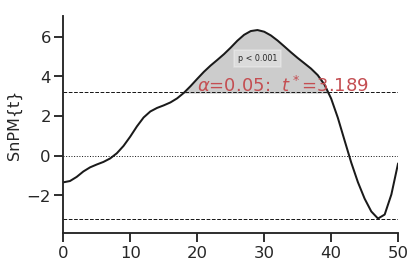

In [54]:
nt_test_inf.plot()
nt_test_inf.plot_p_values()
nt_test_inf.plot_threshold_label()

sns.despine()

In accordance with Pataky's article ([Zero- vs. one-dimensional, parametric vs. non-parametric, and confidence interval vs. hypothesis testing procedures in one-dimensional biomechanical trajectory analysis.](https://www.ncbi.nlm.nih.gov/pubmed/25817475)): 1D parametric and 1D non-parametric hypothesis testing results were qualitatively identical.

This is interesting because the use of a non-parametric model makes it possible to avoid certain hypotheses (normality of the data, homogeneity of the variances, high number of observations).

that's why I use non-parametric statistical models most of the time.

<!--NAVIGATION-->
< [Advanced statistical analysis of biomechanical time series](04.00-Time-series-statistics.ipynb) | [Contents](Index.ipynb) | [Useful programming stuff](05.00-Useful-programming-stuff.ipynb) >